# SGD Визуализация

In [21]:
# Import libraries
import pandas as pd
import numpy as np
import time
import celluloid
import sklearn
from sklearn.preprocessing import OneHotEncoder
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.utils import check_random_state
from matplotlib import animation 
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.special import expit
from celluloid import Camera
import networkx as nx
from matplotlib.animation import FuncAnimation, PillowWriter 

Мы импортируем MNIST в скрипт на Python. Рукописные цифры набора данных MNIST представлены в виде изображений в оттенках серого, поэтому мы можем нормализовать входные данные путём масштабирования значений пикселей из диапазона 0-255 в диапазон 0-1,2 в нашем коде, следовательно, мы делим x-значения на 255.

Загрузка базы данных

In [22]:
# Load data from https://www.openml.org/d/554
X_data, Y_data = fetch_openml(
    "mnist_784", version=1, return_X_y=True, as_frame=False, parser="pandas"
)

X_data=X_data/255 # rescale pixel values to 0-1

oh=OneHotEncoder(categories='auto') 
Y_data_oh=oh.fit_transform(Y_data.reshape(-1,1)).toarray() # one-hot-encoding of y-values

Функция потерь

In [23]:
hidden_0=50 # number of nodes of first hidden layer
hidden_1=500 # number of nodes of second hidden layer

# Set up cost function:
def costs(x,y,w_a,w_b,seed_):  
    np.random.seed(seed_) # insert random seed 
    w0=np.random.randn(hidden_0,784)  # weight matrix of 1st hidden layer
    w1=np.random.randn(hidden_1,hidden_0) # weight matrix of 2nd hidden layer
    w2=np.random.randn(10,hidden_1) # weight matrix of output layer
    w2[5][250] = w_a # set value for weight w_250,5(2)
    w2[5][251] = w_b # set value for weight w_251,5(2)
    a0 = expit(w0 @ x.T)  # output of 1st hidden layer
    a1=expit(w1 @ a0)  # output of 2nd hidden layer
    pred= expit(w2 @ a1) # output of final layer
    return np.mean(np.sum((y-pred)**2,axis=0)) # costs w.r.t. w_a and w_b

Чтобы создать графики, мы определяем диапазоны значений для наших весов и строим сетку, получая таким образом все возможные комбинации значений веса для w_a и w_b соответственно. Для каждой пары w_a и w_b в нашей сетке мы намерены рассчитать соответствующие стоимости с помощью нашей функции стоимости. Далее мы можем, наконец, создать некоторые ландшафты потерь:

In [24]:
# Set range of values for meshgrid: 
m1s = np.linspace(-15, 17, 40)
m2s = np.linspace(-15, 18, 40)  
M1, M2 = np.meshgrid(m1s, m2s) # create meshgrid  
a = 0 

In [25]:
# Determine costs for each coordinate in meshgrid: 
zs_100 = np.array([costs(X_data[0:100],Y_data_oh[0:100].T  
                               ,np.array([[mp1]]), np.array([[mp2]]), 135)  
                       for mp1, mp2 in zip(np.ravel(M1), np.ravel(M2))])
Z_100 = zs_100.reshape(M1.shape) # z-values for N=100


zs_500 = np.array([costs(X_data[0:500],Y_data_oh[0:500].T  
                               ,np.array([[mp1]]), np.array([[mp2]]), 135)  
                       for mp1, mp2 in zip(np.ravel(M1), np.ravel(M2))])
Z_500 = zs_500.reshape(M1.shape) # z-values for N=500



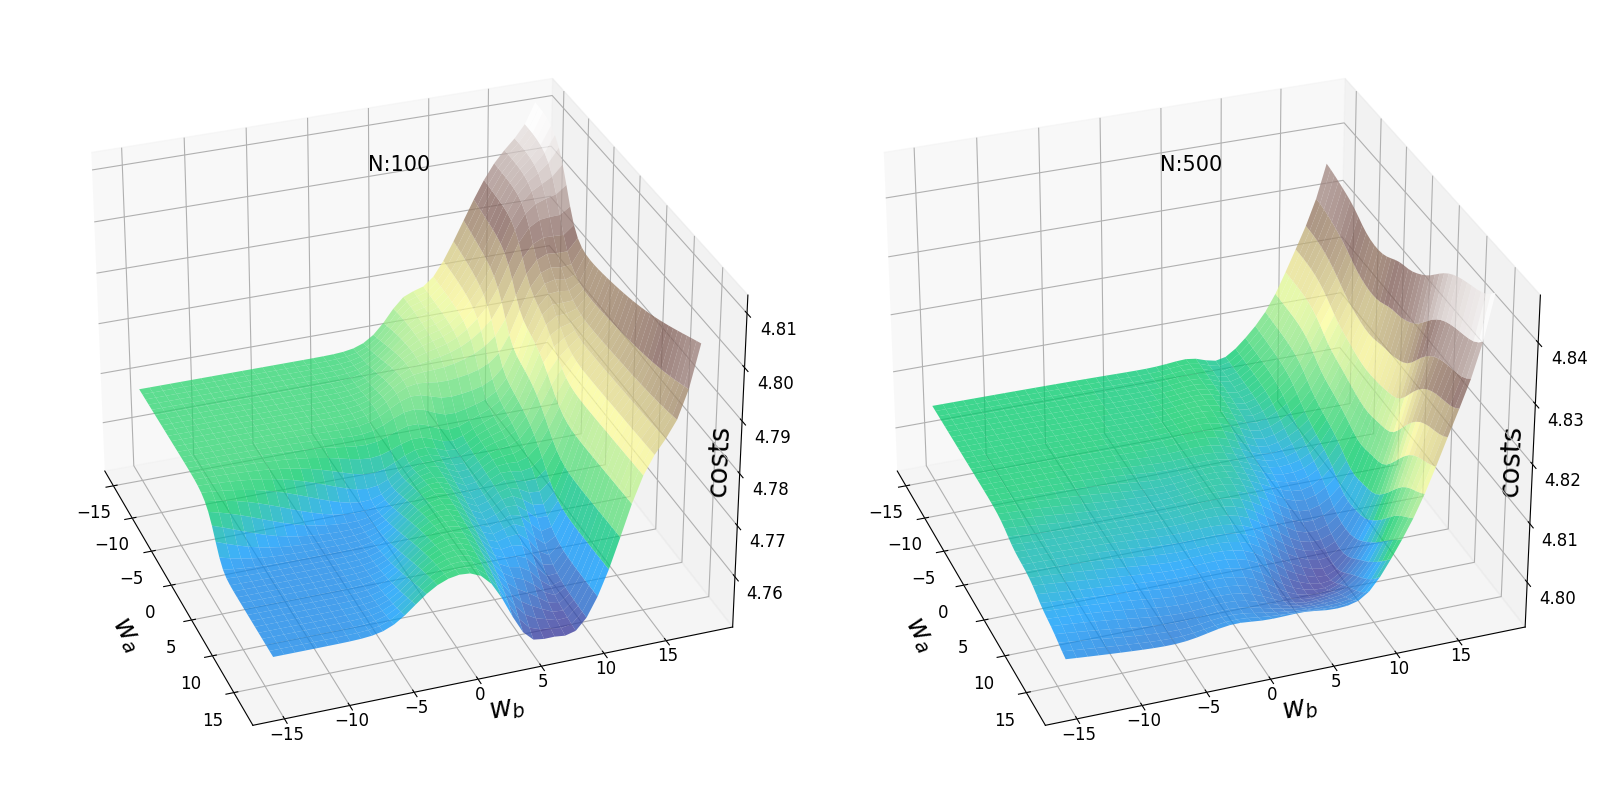

In [26]:
# Plot loss landscapes: 
fig = plt.figure(figsize=(16,9)) # create figure
ax0 = fig.add_subplot(121, projection='3d' )
ax1 = fig.add_subplot(122, projection='3d' )

fontsize_=20 # set axis label fontsize
labelsize_=12 # set tick label size

# Customize subplots: 
ax0.view_init(elev=30, azim=-20)
ax0.set_xlabel(r'$w_a$', fontsize=fontsize_, labelpad=9)
ax0.set_ylabel(r'$w_b$', fontsize=fontsize_, labelpad=-5)
ax0.set_zlabel("costs", fontsize=fontsize_, labelpad=-30)
ax0.tick_params(axis='x', pad=5, which='major', labelsize=labelsize_)
ax0.tick_params(axis='y', pad=-5, which='major', labelsize=labelsize_)
ax0.tick_params(axis='z', pad=5, which='major', labelsize=labelsize_)
ax0.set_title('N:100',y=0.85,fontsize=15) # set title of subplot 

ax1.view_init(elev=30, azim=-20)
ax1.set_xlabel(r'$w_a$', fontsize=fontsize_, labelpad=9)
ax1.set_ylabel(r'$w_b$', fontsize=fontsize_, labelpad=-5)
ax1.set_zlabel("costs", fontsize=fontsize_, labelpad=-30)
ax1.tick_params(axis='y', pad=-5, which='major', labelsize=labelsize_)
ax1.tick_params(axis='x', pad=5, which='major', labelsize=labelsize_)
ax1.tick_params(axis='z', pad=5, which='major', labelsize=labelsize_)
ax1.set_title('N:500',y=0.85,fontsize=15)

# Surface plots of costs (= loss landscapes):  
ax0.plot_surface(M1, M2, Z_100, cmap='terrain', #surface plot
                             antialiased=True,cstride=1,rstride=1, alpha=0.75)
ax1.plot_surface(M1, M2, Z_500, cmap='terrain', #surface plot
                             antialiased=True,cstride=1,rstride=1, alpha=0.75)
plt.tight_layout()
plt.show()

In [27]:
# Store values of costs and weights in lists: 
weights_2_5_250=[] 
weights_2_5_251=[] 
costs=[] 

seed_= 135 # random seed
N=100 # sample size 

# Set up neural network: 
class NeuralNetwork(object):
    def __init__(self, lr=0.01):
        self.lr=lr
        np.random.seed(seed_) # set random seed
        # Intialize weight matrices: 
        self.w0=np.random.randn(hidden_0,784)  
        self.w1=np.random.randn(hidden_1,hidden_0)
        self.w2=np.random.randn(10,hidden_1)
        self.w2[5][250] = start_a # set starting value for w_a
        self.w2[5][251] = start_b # set starting value for w_b
    
    def train(self, X,y):
        a0 = expit(self.w0 @ X.T)  
        a1=expit(self.w1 @ a0)  
        pred= expit(self.w2 @ a1)
        # Partial derivatives of costs w.r.t. the weights of the output layer: 
        dw2= (pred - y.T)*pred*(1-pred)  @ a1.T / len(X)   # ... averaged over the sample size
        # Update weights: 
        self.w2[5][250]=self.w2[5][250] - self.lr * dw2[5][250] 
        self.w2[5][251]=self.w2[5][251] - self.lr * dw2[5][251] 
        costs.append(self.cost(pred,y)) # append cost values to list
    
    def cost(self, pred, y):
        return np.mean(np.sum((y.T-pred)**2,axis=0))
    
# Initial values of w_a/w_b: 
starting_points = [  (-9,15),(-10.1,15),(-11,15)] 

for j in starting_points:
    start_a,start_b=j
    model=NeuralNetwork(10) # set learning rate to 10
    for i in range(10000):  # 10,000 epochs            
        model.train(X_data[0:N], Y_data_oh[0:N]) 
        weights_2_5_250.append(model.w2[5][250]) # append weight values to list
        weights_2_5_251.append(model.w2[5][251]) # append weight values to list

# Create sublists of costs and weight values for each starting point: 
costs = np.split(np.array(costs),3) 
weights_2_5_250 = np.split(np.array(weights_2_5_250),3)
weights_2_5_251 = np.split(np.array(weights_2_5_251),3)


MovieWriter imagemagick unavailable; using Pillow instead.


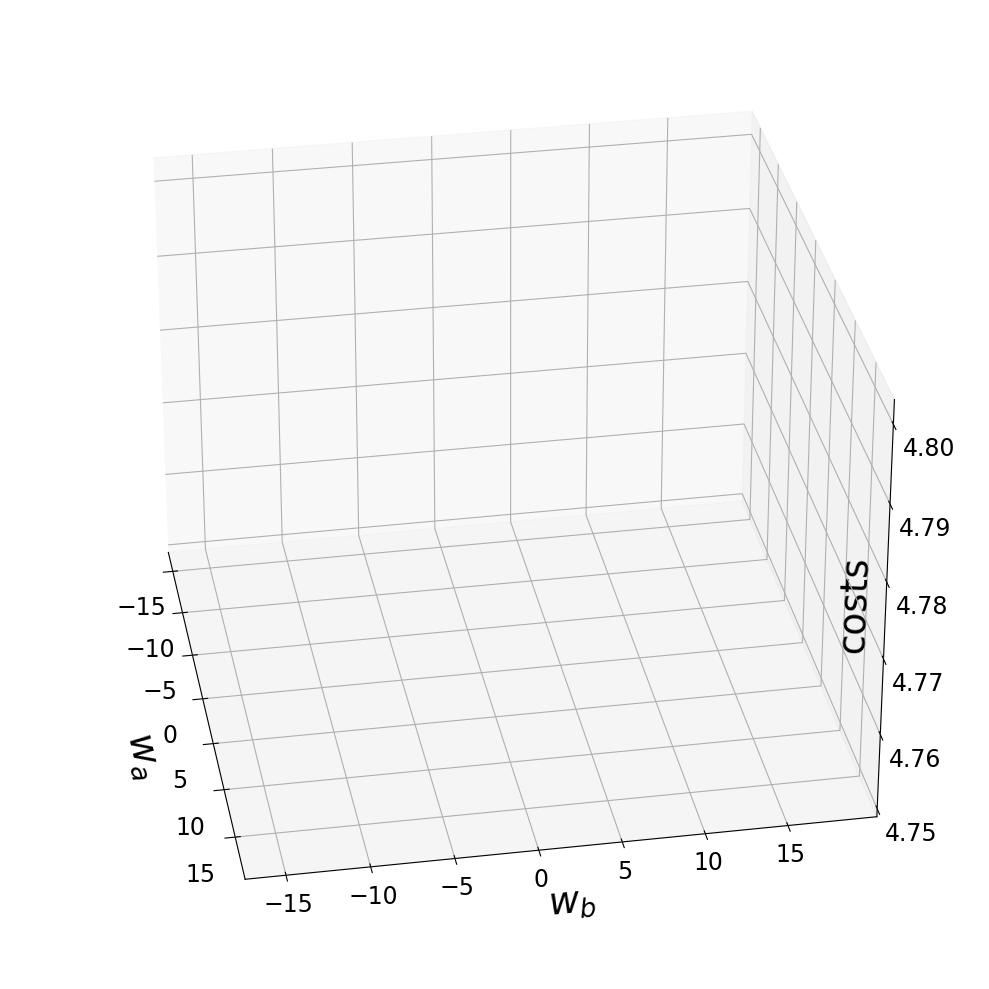

In [28]:
fig = plt.figure(figsize=(10,10)) # create figure
ax = fig.add_subplot(111,projection='3d' ) 
line_style=["dashed", "dashdot", "dotted"] #linestyles
fontsize_=27 # set axis label fontsize
labelsize_=17 # set tick label fontsize
ax.view_init(elev=30, azim=-10)
ax.set_xlabel(r'$w_a$', fontsize=fontsize_, labelpad=17)
ax.set_ylabel(r'$w_b$', fontsize=fontsize_, labelpad=5)
ax.set_zlabel("costs", fontsize=fontsize_, labelpad=-35)
ax.tick_params(axis='x', pad=12, which='major', labelsize=labelsize_)
ax.tick_params(axis='y', pad=0, which='major', labelsize=labelsize_)
ax.tick_params(axis='z', pad=8, which='major', labelsize=labelsize_)
ax.set_zlim(4.75,4.802) # set range for z-values in the plot

# Define which epochs to plot:
p1=list(np.arange(0,200,20))
p2=list(np.arange(200,9000,100))
points_=p1+p2

camera=Camera(fig) # create Camera object
for i in points_:
    # Plot the three trajectories of gradient descent...
    #... each starting from its respective starting point
    #... and each with a unique linestyle:
    for j in range(3): 
        ax.plot(weights_2_5_250[j][0:i],weights_2_5_251[j][0:i],costs[j][0:i],
                linestyle=line_style[j],linewidth=2,
                color="black", label=str(i))
        ax.scatter(weights_2_5_250[j][i],weights_2_5_251[j][i],costs[j][i],
                   marker='o', s=15**2,
               color="black", alpha=1.0)
    # Surface plot (= loss landscape):
    ax.plot_surface(M1, M2, Z_100, cmap='terrain', 
                             antialiased=True,cstride=1,rstride=1, alpha=0.75)
    ax.legend([f'epochs: {i}'], loc=(0.25, 0.8),fontsize=17) # set position of legend
    plt.tight_layout() 
    camera.snap() # take snapshot after each iteration
    
animation = camera.animate(interval = 5, # set delay between frames in milliseconds
                          repeat = False,
                          repeat_delay = 0)
animation.save('imgs/gd_1.gif', writer = 'imagemagick', dpi=100)  # save animation

In [29]:
fig = plt.figure(figsize=(10,10)) # create figure
ax0=fig.add_subplot(2, 1, 1) 
ax1=fig.add_subplot(2, 1, 2) 

# Customize subplots: 
ax0.set_xlabel(r'$w_a$', fontsize=25, labelpad=0)
ax0.set_ylabel(r'$w_b$', fontsize=25, labelpad=-20)
ax0.tick_params(axis='both', which='major', labelsize=17)
ax1.set_xlabel("epochs", fontsize=22, labelpad=5)
ax1.set_ylabel("costs", fontsize=25, labelpad=7)
ax1.tick_params(axis='both', which='major', labelsize=17)

contours_=21 # set the number of contour lines
points_=np.arange(0,9000,100) # define which epochs to plot

camera = Camera(fig) # create Camera object
for i in points_:
    cf=ax0.contour(M1, M2, Z_100,contours_, colors='black', # contour plot
                     linestyles='dashed', linewidths=1)
    ax0.contourf(M1, M2, Z_100, alpha=0.85,cmap='terrain') # filled contour plots 
    
    for j in range(3):
        ax0.scatter(weights_2_5_250[j][i],weights_2_5_251[j][i],marker='o', s=13**2,
               color="black", alpha=1.0)
        ax0.plot(weights_2_5_250[j][0:i],weights_2_5_251[j][0:i],
                linestyle=line_style[j],linewidth=2,
                color="black", label=str(i))
        
        ax1.plot(costs[j][0:i], color="black", linestyle=line_style[j])
    plt.tight_layout()
    camera.snap()
    
animation = camera.animate(interval = 5,
                          repeat = True, repeat_delay = 0)  # create animation 
animation.save('imgs/gd_2.gif', writer = 'imagemagick')  # save animation as gif